### Import required Packages and gathering Data

In [260]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [65]:
crop_df = pd.read_excel("Crop_data.xlsx", sheet_name="Sheet1")
crop_yield_df = pd.read_csv("D:/All_Projects/splitmindz/Crop_Yield_Prediction.csv")
# concat_df = pd.concat([crop_df, crop_yield_df], axis = 1)
crop_yield_df.describe()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Yield
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655,2689.228182
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389,3710.361267
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267,2.000000
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686,950.000000
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624,1825.000000
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508,3500.000000
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117,120000.000000


In [66]:
weather_data = pd.DataFrame({
    "Humidity":np.random.uniform(15, 100, len(crop_df)),
    "pH_Value": np.random.uniform(3, 10, len(crop_df)),
    'temperature': np.random.uniform(8, 45, len(crop_df)),  # Random temperatures between 20 and 35 degrees Celsius
    'rainfall': np.random.uniform(20, 300, len(crop_df))      # Random rainfall between 0 and 20 mm
})

# Generate synthetic market trend data
market_data = pd.DataFrame({
    'demand_index': np.random.uniform(80, 150, len(crop_df)),  # Random demand index between 80 and 150
    'supply_index': np.random.uniform(90, 120, len(crop_df))   # Random supply index between 90 and 120
})

weather_data.describe()
market_data.describe()

,demand_index,supply_index
count,132.000000,132.000000
mean,115.647115,104.890729
std,19.618529,8.525002
min,80.747953,90.248551
25%,97.731715,96.452136
50%,116.189196,105.934449
75%,133.327582,111.775533
max,148.810007,119.885382


In [67]:
concated_data = pd.concat([crop_df, weather_data, market_data], axis = 1)
concated_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Sowing_Date,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,2024-01-15,Tillage,NaN,100,6129.856,84.834811,9.067378,39.937426,187.437490,141.278582,92.999164
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,2024-01-20,NaN,NaN,100,5446.704,85.894892,5.072109,34.159178,274.226948,142.002445,94.481521
2,Maharashtra,Ahmednagar,Ragi,27.05,Preparation,Fertilizer application,2024-01-25,Organic manure,NaN,100,5985.228,79.649852,7.186445,38.807784,175.314058,130.237297,104.941653
3,Maharashtra,Ahmednagar,Ragi,34.08,Preparation,Seed selection,2024-01-30,NaN,NaN,100,5886.888,21.103355,4.319409,15.008008,208.560083,94.149667,114.161379
4,Maharashtra,Pune,Ragi,29.76,Preparation,Plowing,2024-01-20,Tillage,NaN,150,7170.876,58.622013,9.686327,37.475454,91.843447,109.882740,99.136927


In [68]:
concated_data.columns

Index(['State', 'District', 'Crop', 'Current_price', 'Stage',
       'Preparation_Activity', 'Sowing_Date', 'Fertilization', 'Irrigation',
       'Area (in hectares)', 'Required Production per Year', 'Humidity',
       'pH_Value', 'temperature', 'rainfall', 'demand_index', 'supply_index'],
      dtype='object')

In [69]:
concated_data.isnull().sum()

State                             0
District                          0
Crop                              0
Current_price                     0
Stage                             0
Preparation_Activity              0
Sowing_Date                       0
Fertilization                    66
Irrigation                      132
Area (in hectares)                0
Required Production per Year      0
Humidity                          0
pH_Value                          0
temperature                       0
rainfall                          0
demand_index                      0
supply_index                      0
dtype: int64

### Anaysis and Preprocessing

#### Analysis

In [70]:
concated_data.shape

(132, 17)

In [71]:
concated_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Sowing_Date,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,2024-01-15,Tillage,NaN,100,6129.856,84.834811,9.067378,39.937426,187.437490,141.278582,92.999164
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,2024-01-20,NaN,NaN,100,5446.704,85.894892,5.072109,34.159178,274.226948,142.002445,94.481521
2,Maharashtra,Ahmednagar,Ragi,27.05,Preparation,Fertilizer application,2024-01-25,Organic manure,NaN,100,5985.228,79.649852,7.186445,38.807784,175.314058,130.237297,104.941653
3,Maharashtra,Ahmednagar,Ragi,34.08,Preparation,Seed selection,2024-01-30,NaN,NaN,100,5886.888,21.103355,4.319409,15.008008,208.560083,94.149667,114.161379
4,Maharashtra,Pune,Ragi,29.76,Preparation,Plowing,2024-01-20,Tillage,NaN,150,7170.876,58.622013,9.686327,37.475454,91.843447,109.882740,99.136927


In [72]:
concated_data.tail()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Sowing_Date,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index
127,Madhya Pradesh,Jabalpur,Maize,33.17,Preparation,Seed selection,2024-02-10,NaN,NaN,300,6220.368,40.211236,7.190211,39.146453,177.296310,124.484976,105.841025
128,Madhya Pradesh,Gwalior,Maize,30.42,Preparation,Plowing,2024-01-20,Tillage,NaN,350,5451.144,24.052704,9.121651,20.670270,82.687539,133.827487,102.147181
129,Madhya Pradesh,Gwalior,Maize,31.81,Preparation,Weeding,2024-01-25,NaN,NaN,350,6383.148,57.235914,9.357474,29.579833,209.334621,128.990053,115.776459
130,Madhya Pradesh,Gwalior,Maize,32.67,Preparation,Fertilizer application,2024-01-30,Organic manure,NaN,350,6325.464,15.484611,4.279528,38.515632,237.147033,105.398087,115.713400
131,Madhya Pradesh,Gwalior,Maize,29.79,Preparation,Seed selection,2024-02-05,NaN,NaN,350,6001.548,43.903944,3.231330,26.099129,44.018633,126.420907,108.697735


In [73]:
concated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   State                         132 non-null    object        
 1   District                      132 non-null    object        
 2   Crop                          132 non-null    object        
 3   Current_price                 132 non-null    float64       
 4   Stage                         132 non-null    object        
 5   Preparation_Activity          132 non-null    object        
 6   Sowing_Date                   132 non-null    datetime64[ns]
 7   Fertilization                 66 non-null     object        
 8   Irrigation                    0 non-null      float64       
 9   Area (in hectares)            132 non-null    int64         
 10  Required Production per Year  132 non-null    float64       
 11  Humidity                      13

In [74]:
concated_data["Crop"].value_counts()

Crop
Wheat        24
Ragi         16
Onion        16
Rice         16
Tomato       12
Sorghum       8
Barley        8
Groundnut     8
Cotton        8
Soybean       8
Maize         8
Name: count, dtype: int64

In [75]:
concated_data.describe(include="O")

,State,District,Crop,Stage,Preparation_Activity,Fertilization
count,132,132,132,132,132,66
unique,8,33,11,1,4,2
top,Maharashtra,Ahmednagar,Wheat,Preparation,Plowing,Tillage
freq,20,4,24,132,33,33


In [76]:
concated_data.describe()

,Current_price,Sowing_Date,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index
count,132.000000,132,0.0,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,30.430606,2024-05-15 10:54:32.727272704,NaN,254.545455,6073.584152,54.805972,6.423821,26.025188,150.992258,115.647115,104.890729
min,25.610000,2024-01-15 00:00:00,NaN,100.000000,4736.808000,15.277152,3.026786,8.118487,20.153168,80.747953,90.248551
25%,29.035000,2024-02-04 00:00:00,NaN,200.000000,5700.297000,34.911792,4.739022,16.475500,85.807517,97.731715,96.452136
50%,30.425000,2024-02-27 12:00:00,NaN,250.000000,6048.282000,54.521185,6.381553,25.502100,147.154290,116.189196,105.934449
75%,31.912500,2024-10-20 00:00:00,NaN,300.000000,6405.942000,76.992338,8.439751,35.781695,211.568626,133.327582,111.775533
max,34.670000,2024-11-05 00:00:00,NaN,350.000000,7357.548000,99.859134,9.996109,44.486633,298.479364,148.810007,119.885382
std,1.956230,NaN,NaN,68.085752,567.756690,25.550123,2.103684,10.942250,80.534722,19.618529,8.525002


In [441]:
categorical_features = ['State', 'District', 'Stage', 'Crop', 'Preparation_Activity', 'Fertilization', 'Irrigation']
numerical_features = ['Current_price','Area (in hectares)', 'Required Production per Year', 'Humidity', 'pH_Value', 'temperature', 'rainfall', 'demand_index', 'supply_index']

In [449]:
crop_summary = pd.pivot_table(concated_data[numerical_features], index = concated_data["Crop"], aggfunc="mean")
crop_summary.reset_index()
# plt.figure(figsize=(10,5))
# sns.heatmap(crop_summary, annot=True, fmt = ".2f")
# plt.show()

,Crop,Area (in hectares),Current_price,Humidity,Required Production per Year,demand_index,pH_Value,rainfall,supply_index,temperature
0,Barley,325.000000,30.766250,59.753694,6094.879500,113.687128,7.636405,138.852167,103.773470,20.829723
1,Cotton,325.000000,30.511250,49.838215,6213.585000,130.694463,6.934099,142.048277,108.903839,23.191214
2,Groundnut,225.000000,30.107500,68.182784,6107.410500,129.913948,5.367606,160.348035,108.869415,23.886589
3,Maize,325.000000,31.055000,48.834692,6106.380000,123.850022,5.883027,149.063902,103.755761,31.656217
4,Onion,225.000000,30.419375,43.111242,5881.728000,106.532566,6.842237,141.052155,107.150930,22.694631
5,Ragi,175.000000,29.840000,54.398061,6053.216500,113.530374,6.285666,183.994369,101.020682,27.890208
6,Rice,225.000000,30.186250,58.623096,6084.391500,115.361406,5.981422,149.515463,106.228423,29.612196
7,Sorghum,225.000000,31.146250,59.456007,5941.108500,113.935150,5.485971,178.921690,101.083336,30.923134
8,Soybean,225.000000,30.343750,60.647405,5960.797500,116.054369,6.775982,94.218883,103.100905,22.310811
9,Tomato,216.666667,30.346667,53.007821,6228.097000,110.923639,6.815546,125.144009,105.127336,20.125985


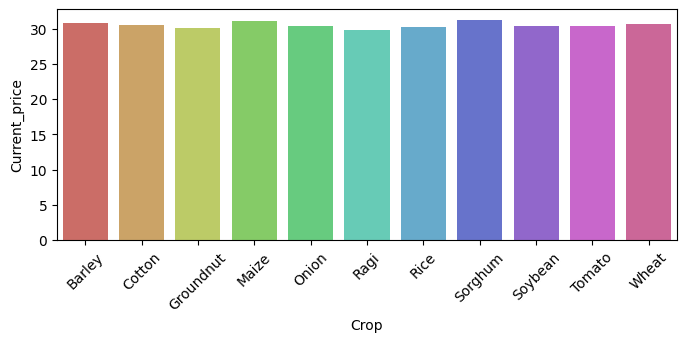

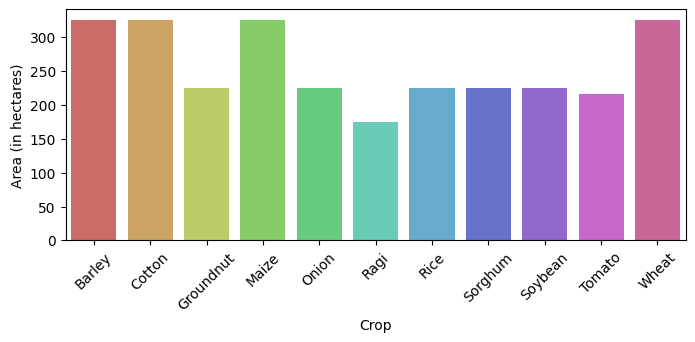

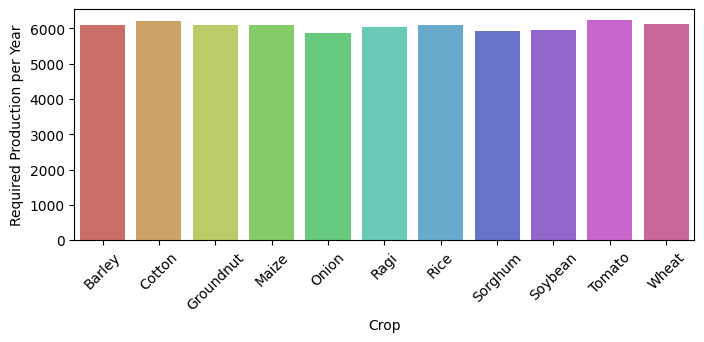

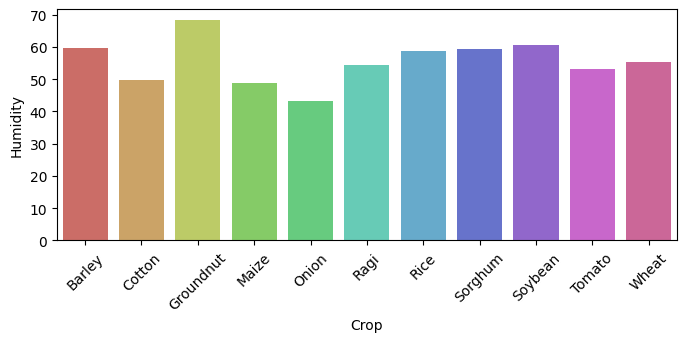

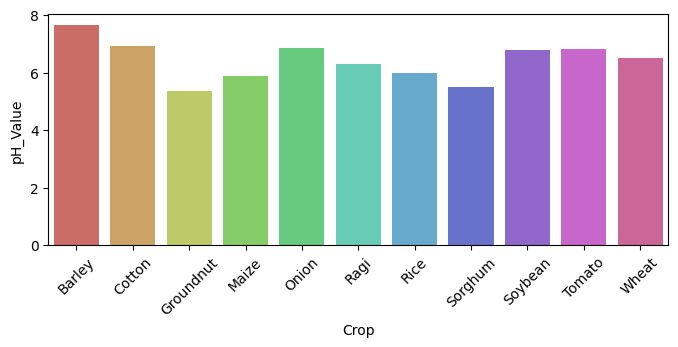

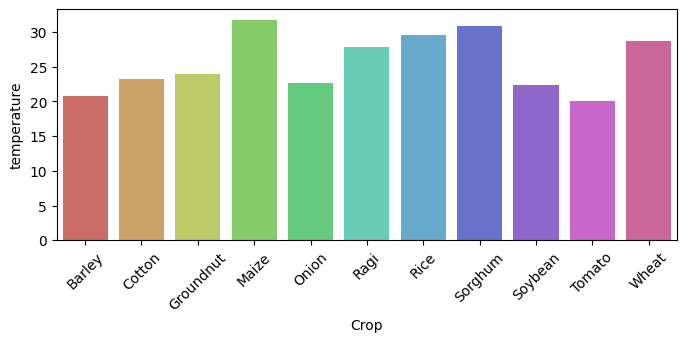

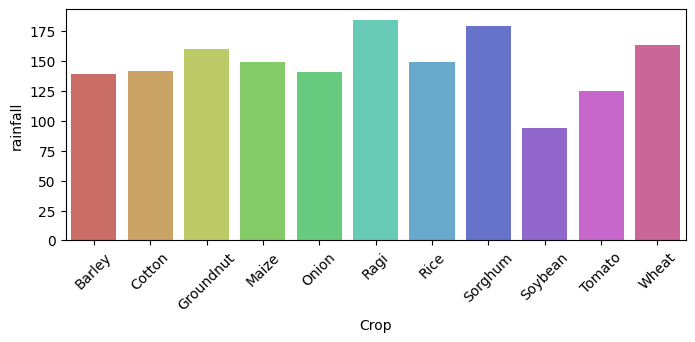

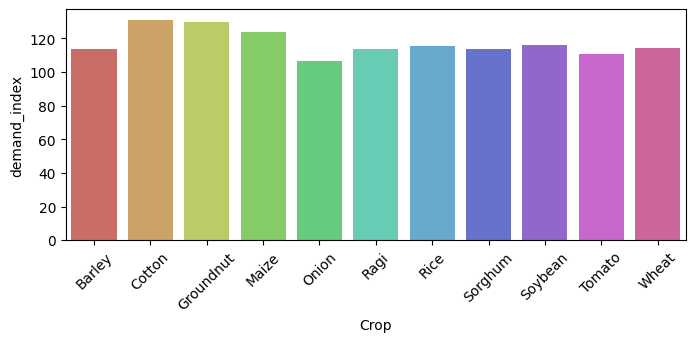

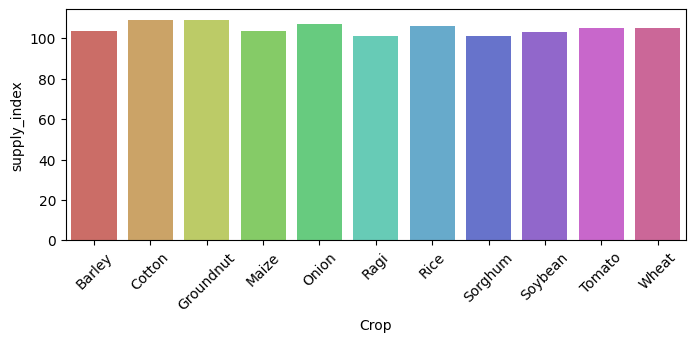

In [455]:
for i in crop_summary[numerical_features].columns:
    plt.figure(figsize=(8,3))
    sns.barplot(x = "Crop", y = i, data=crop_summary, palette='hls')
    plt.xticks(rotation = 45)

#### Handling Missing values

In [84]:
crop_data = concated_data.copy()

In [85]:
crop_data.isna().sum()

State                             0
District                          0
Crop                              0
Current_price                     0
Stage                             0
Preparation_Activity              0
Sowing_Date                       0
Fertilization                    66
Irrigation                      132
Area (in hectares)                0
Required Production per Year      0
Humidity                          0
pH_Value                          0
temperature                       0
rainfall                          0
demand_index                      0
supply_index                      0
dtype: int64

In [86]:
crop_data["Fertilization"].value_counts()

Fertilization
Tillage           33
Organic manure    33
Name: count, dtype: int64

In [87]:
crop_data["Irrigation"].value_counts()

Series([], Name: count, dtype: int64)

In [88]:
crop_data["Preparation_Activity"].value_counts()

Preparation_Activity
Plowing                   33
Weeding                   33
Fertilizer application    33
Seed selection            33
Name: count, dtype: int64

In [89]:
crop_data["Crop"].value_counts()

Crop
Wheat        24
Ragi         16
Onion        16
Rice         16
Tomato       12
Sorghum       8
Barley        8
Groundnut     8
Cotton        8
Soybean       8
Maize         8
Name: count, dtype: int64

In [90]:
# crop_data.to_csv("merged_crop_df.csv")

In [91]:
# Define irrigation rules based on crop type and sowing season
def determine_irrigation(row):
    crop = row['Crop']
    if crop == 'Rice':
        return 'Flood'
    elif crop in ['Wheat', 'Barley', 'Ragi', 'Sorghum', 'Groundnut', 'Soybean', 'Maize']:
        return 'Sprinkler'
    elif crop in ['Tomato', 'Onion', 'Cotton']:
        return 'Drip'
    else:
        return 'None'

In [92]:
# Apply the function to create the 'Irrigation' feature
crop_data['Irrigation'] = crop_data.apply(determine_irrigation, axis=1)

In [93]:
crop_data["Irrigation"].value_counts()

Irrigation
Sprinkler    80
Drip         36
Flood        16
Name: count, dtype: int64

In [94]:
crop_data.isnull().sum()

State                            0
District                         0
Crop                             0
Current_price                    0
Stage                            0
Preparation_Activity             0
Sowing_Date                      0
Fertilization                   66
Irrigation                       0
Area (in hectares)               0
Required Production per Year     0
Humidity                         0
pH_Value                         0
temperature                      0
rainfall                         0
demand_index                     0
supply_index                     0
dtype: int64

In [95]:
crop_data.ffill(inplace=True)

In [96]:
crop_data.isnull().sum()

State                           0
District                        0
Crop                            0
Current_price                   0
Stage                           0
Preparation_Activity            0
Sowing_Date                     0
Fertilization                   0
Irrigation                      0
Area (in hectares)              0
Required Production per Year    0
Humidity                        0
pH_Value                        0
temperature                     0
rainfall                        0
demand_index                    0
supply_index                    0
dtype: int64

In [97]:
crop_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Sowing_Date,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,2024-01-15,Tillage,Sprinkler,100,6129.856,84.834811,9.067378,39.937426,187.437490,141.278582,92.999164
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,2024-01-20,Tillage,Sprinkler,100,5446.704,85.894892,5.072109,34.159178,274.226948,142.002445,94.481521
2,Maharashtra,Ahmednagar,Ragi,27.05,Preparation,Fertilizer application,2024-01-25,Organic manure,Sprinkler,100,5985.228,79.649852,7.186445,38.807784,175.314058,130.237297,104.941653
3,Maharashtra,Ahmednagar,Ragi,34.08,Preparation,Seed selection,2024-01-30,Organic manure,Sprinkler,100,5886.888,21.103355,4.319409,15.008008,208.560083,94.149667,114.161379
4,Maharashtra,Pune,Ragi,29.76,Preparation,Plowing,2024-01-20,Tillage,Sprinkler,150,7170.876,58.622013,9.686327,37.475454,91.843447,109.882740,99.136927


In [98]:
crop_data["Fertilization"].value_counts()

Fertilization
Tillage           66
Organic manure    66
Name: count, dtype: int64

In [99]:
handle_missing_crop_data = crop_data.copy()

#### Feature Engineering

In [100]:
# Date Feature Engineering
handle_missing_crop_data['Sowing_Date'] = pd.to_datetime(handle_missing_crop_data['Sowing_Date'], errors='coerce')
handle_missing_crop_data['Sowing_Month'] = handle_missing_crop_data['Sowing_Date'].dt.month
handle_missing_crop_data['Sowing_Season'] = handle_missing_crop_data['Sowing_Date'].dt.quarter
handle_missing_crop_data['Days_Since_Sowing'] = (datetime.now() - handle_missing_crop_data['Sowing_Date']).dt.days

In [101]:
# Drop original Sowing_Date as we have extracted useful features
handle_missing_crop_data.drop(columns=['Sowing_Date'], inplace=True)

In [102]:
handle_missing_crop_data["Sowing_Season"].value_counts()

Sowing_Season
1    83
4    48
2     1
Name: count, dtype: int64

In [103]:
feature_engineer_crop_data = handle_missing_crop_data.copy()
feature_engineer_crop_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,Tillage,Sprinkler,100,6129.856,84.834811,9.067378,39.937426,187.437490,141.278582,92.999164,1,1,227
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,Tillage,Sprinkler,100,5446.704,85.894892,5.072109,34.159178,274.226948,142.002445,94.481521,1,1,222
2,Maharashtra,Ahmednagar,Ragi,27.05,Preparation,Fertilizer application,Organic manure,Sprinkler,100,5985.228,79.649852,7.186445,38.807784,175.314058,130.237297,104.941653,1,1,217
3,Maharashtra,Ahmednagar,Ragi,34.08,Preparation,Seed selection,Organic manure,Sprinkler,100,5886.888,21.103355,4.319409,15.008008,208.560083,94.149667,114.161379,1,1,212
4,Maharashtra,Pune,Ragi,29.76,Preparation,Plowing,Tillage,Sprinkler,150,7170.876,58.622013,9.686327,37.475454,91.843447,109.882740,99.136927,1,1,222


#### Handling Outliers

In [170]:
feature_engineer_crop_data.describe()

,Current_price,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,30.430606,254.545455,6073.584152,54.805972,6.423821,26.025188,150.992258,115.647115,104.890729,4.871212,2.098485,105.545455
std,1.956230,68.085752,567.756690,25.550123,2.103684,10.942250,80.534722,19.618529,8.525002,4.038754,1.445498,124.605721
min,25.610000,100.000000,4736.808000,15.277152,3.026786,8.118487,20.153168,80.747953,90.248551,1.000000,1.000000,-68.000000
25%,29.035000,200.000000,5700.297000,34.911792,4.739022,16.475500,85.807517,97.731715,96.452136,2.000000,1.000000,-52.000000
50%,30.425000,250.000000,6048.282000,54.521185,6.381553,25.502100,147.154290,116.189196,105.934449,2.500000,1.000000,183.500000
75%,31.912500,300.000000,6405.942000,76.992338,8.439751,35.781695,211.568626,133.327582,111.775533,10.000000,4.000000,207.000000
max,34.670000,350.000000,7357.548000,99.859134,9.996109,44.486633,298.479364,148.810007,119.885382,11.000000,4.000000,227.000000


In [171]:
def detect_outliers(df):
    l = []
    for i in df.columns:
        if df[i].dtypes != "O":
            Q1 = np.percentile(df[i], 25)
            Q3 = np.percentile(df[i], 75)
            IQR = Q3-Q1
            Quartile_dev = (Q3-Q1)/2
            up = Q3 + 1.5*IQR
            lb = Q1 - 1.5*IQR
            std = df[i].std()
            l.append([np.round(j, 2) for j in [Q1, Q3, IQR, Quartile_dev, up, lb, std]])
            get_outlier = df[(df[i]<lb) | (df[i]>up)]
    return get_outlier

In [172]:
detect_outliers(feature_engineer_crop_data)

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing


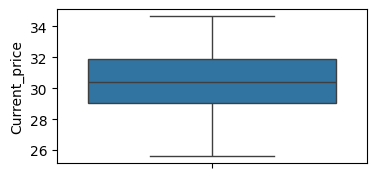

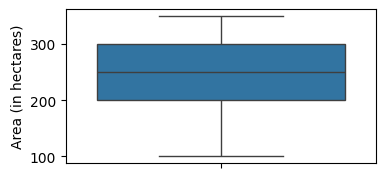

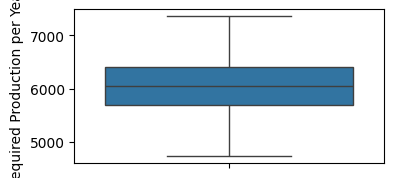

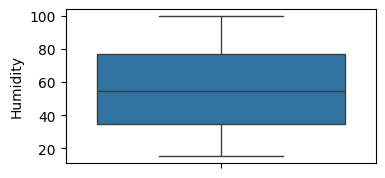

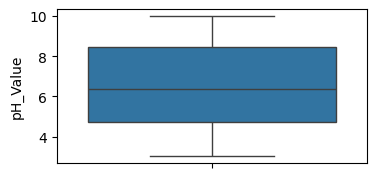

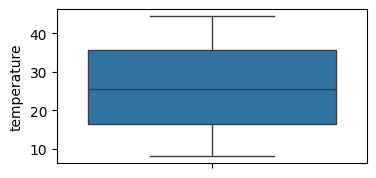

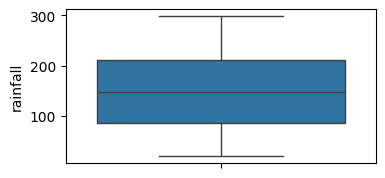

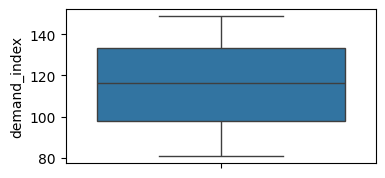

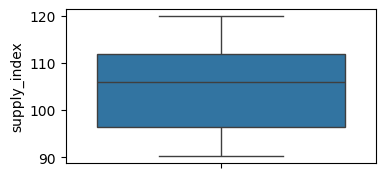

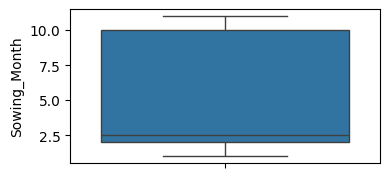

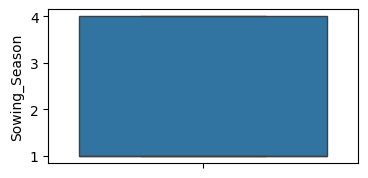

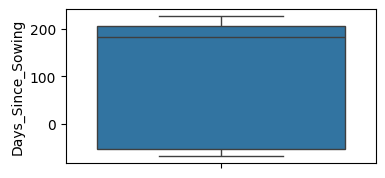

In [173]:
for i in feature_engineer_crop_data.columns:
      if feature_engineer_crop_data[i].dtypes != "O":
        plt.figure(figsize=(4,2))
        sns.boxplot(feature_engineer_crop_data[i])
        plt.show()

In [337]:
detect_outliers_crop_data = feature_engineer_crop_data.copy()

In [338]:
detect_outliers_crop_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing
0,Maharashtra,Ahmednagar,Ragi,28.39,Preparation,Plowing,Tillage,Sprinkler,100,6129.856,84.834811,9.067378,39.937426,187.437490,141.278582,92.999164,1,1,227
1,Maharashtra,Ahmednagar,Ragi,25.71,Preparation,Weeding,Tillage,Sprinkler,100,5446.704,85.894892,5.072109,34.159178,274.226948,142.002445,94.481521,1,1,222
2,Maharashtra,Ahmednagar,Ragi,27.05,Preparation,Fertilizer application,Organic manure,Sprinkler,100,5985.228,79.649852,7.186445,38.807784,175.314058,130.237297,104.941653,1,1,217
3,Maharashtra,Ahmednagar,Ragi,34.08,Preparation,Seed selection,Organic manure,Sprinkler,100,5886.888,21.103355,4.319409,15.008008,208.560083,94.149667,114.161379,1,1,212
4,Maharashtra,Pune,Ragi,29.76,Preparation,Plowing,Tillage,Sprinkler,150,7170.876,58.622013,9.686327,37.475454,91.843447,109.882740,99.136927,1,1,222


In [339]:
categorical_features = ['State', 'District', 'Stage', 'Crop', 'Preparation_Activity', 'Fertilization', 'Irrigation']
numerical_features = ['Area (in hectares)', 'Required Production per Year', 'Sowing_Month', 'Sowing_Season', 'Days_Since_Sowing']

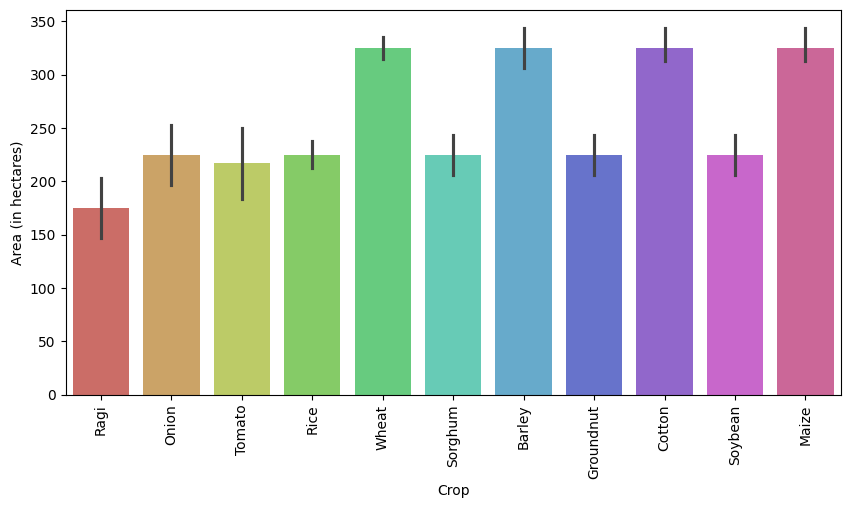

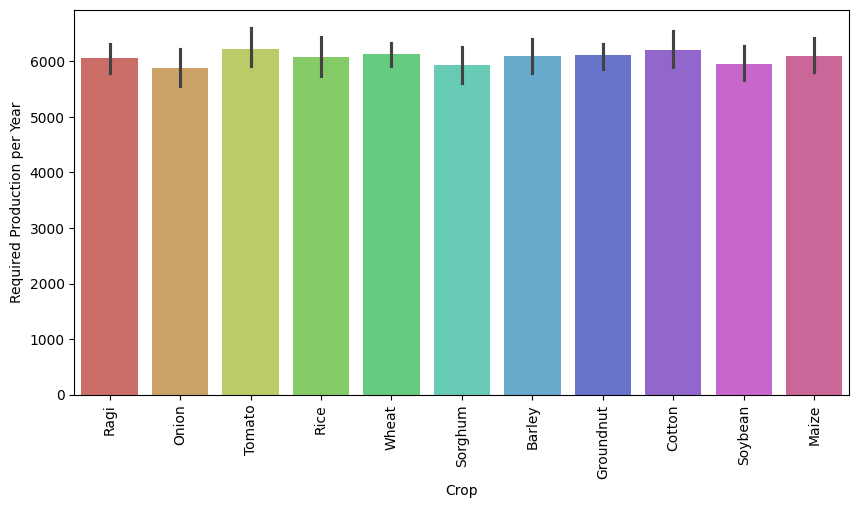

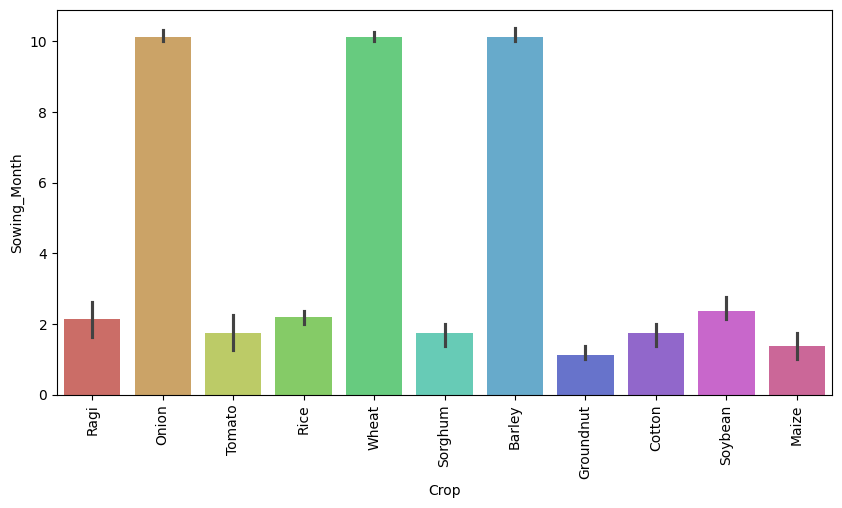

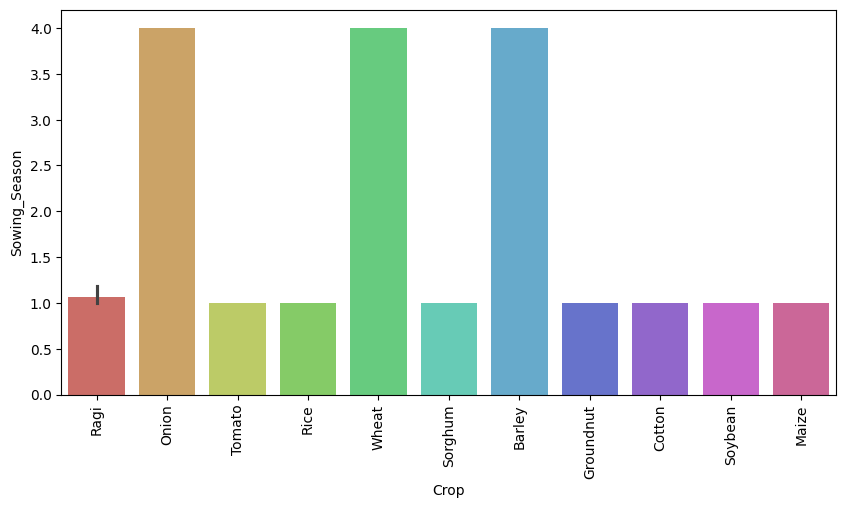

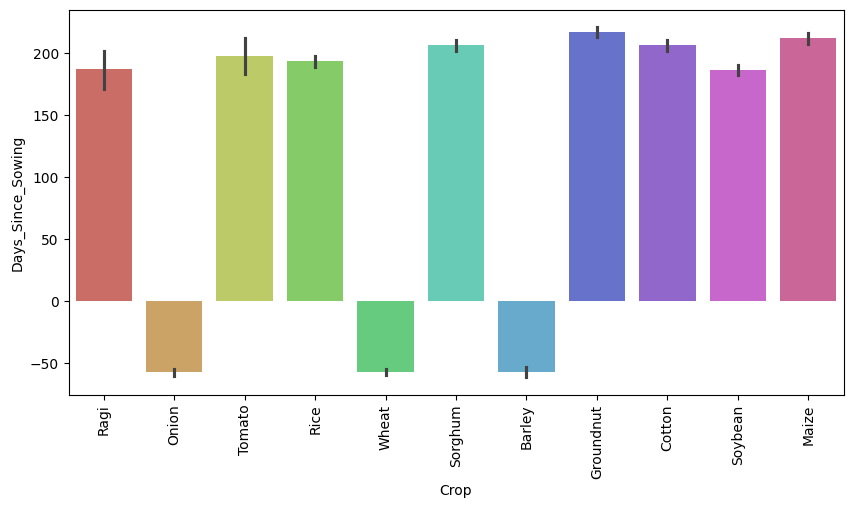

In [340]:
for i in detect_outliers_crop_data[numerical_features].columns:
    plt.figure(figsize=(10,5))
    sns.barplot(x = "Crop", y = i, data=detect_outliers_crop_data, palette='hls')
    plt.xticks(rotation = 90)

In [341]:
# detect_outliers_crop_data[detect_outliers_crop_data["Days_Since_Sowing"]<0]
detect_outliers_crop_data["Days_Since_Sowing"] = detect_outliers_crop_data["Days_Since_Sowing"].abs()
detect_outliers_crop_data[detect_outliers_crop_data["Days_Since_Sowing"]<0]

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing


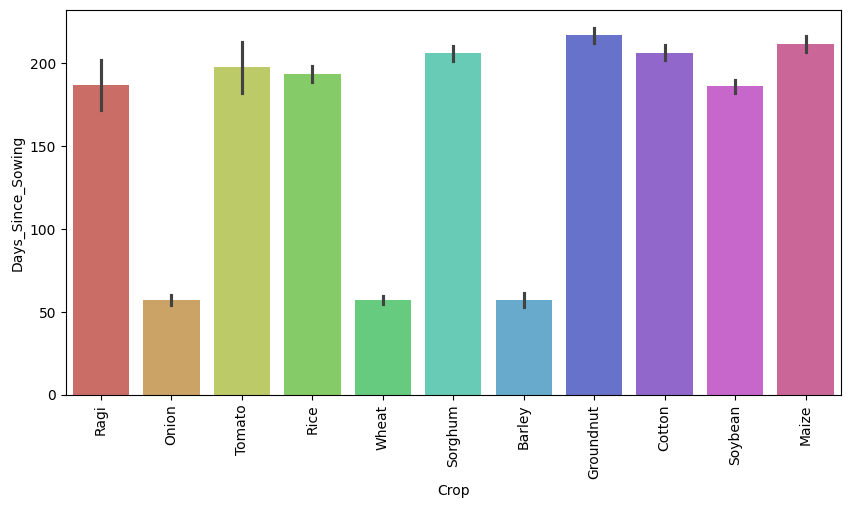

In [342]:
plt.figure(figsize=(10,5))
sns.barplot(x = "Crop", y = "Days_Since_Sowing", data=detect_outliers_crop_data, palette='hls')
plt.xticks(rotation = 90)
plt.show()

#### Encoding categorical features

In [343]:
anomaly_crop_data = detect_outliers_crop_data.copy()

In [344]:
anomaly_crop_data.dtypes

State                            object
District                         object
Crop                             object
Current_price                   float64
Stage                            object
Preparation_Activity             object
Fertilization                    object
Irrigation                       object
Area (in hectares)                int64
Required Production per Year    float64
Humidity                        float64
pH_Value                        float64
temperature                     float64
rainfall                        float64
demand_index                    float64
supply_index                    float64
Sowing_Month                      int32
Sowing_Season                     int32
Days_Since_Sowing                 int64
dtype: object

In [345]:
le = LabelEncoder()
for i in anomaly_crop_data[categorical_features]:
    anomaly_crop_data[i] = le.fit_transform(anomaly_crop_data[i])


In [348]:
anomaly_crop_data.dtypes

State                             int32
District                          int32
Crop                              int32
Current_price                   float64
Stage                             int32
Preparation_Activity              int32
Fertilization                     int32
Irrigation                        int32
Area (in hectares)                int64
Required Production per Year    float64
Humidity                        float64
pH_Value                        float64
temperature                     float64
rainfall                        float64
demand_index                    float64
supply_index                    float64
Sowing_Month                      int32
Sowing_Season                     int32
Days_Since_Sowing                 int64
dtype: object

In [349]:
anomaly_crop_data.head()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing
0,3,2,5,28.39,0,1,1,2,100,6129.856,84.834811,9.067378,39.937426,187.437490,141.278582,92.999164,1,1,227
1,3,2,5,25.71,0,3,1,2,100,5446.704,85.894892,5.072109,34.159178,274.226948,142.002445,94.481521,1,1,222
2,3,2,5,27.05,0,0,0,2,100,5985.228,79.649852,7.186445,38.807784,175.314058,130.237297,104.941653,1,1,217
3,3,2,5,34.08,0,2,0,2,100,5886.888,21.103355,4.319409,15.008008,208.560083,94.149667,114.161379,1,1,212
4,3,25,5,29.76,0,1,1,2,150,7170.876,58.622013,9.686327,37.475454,91.843447,109.882740,99.136927,1,1,222


In [350]:
anomaly_crop_data.describe()

,State,District,Crop,Current_price,Stage,Preparation_Activity,Fertilization,Irrigation,Area (in hectares),Required Production per Year,Humidity,pH_Value,temperature,rainfall,demand_index,supply_index,Sowing_Month,Sowing_Season,Days_Since_Sowing
count,132.000000,132.000000,132.000000,132.000000,132.0,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,3.484848,16.000000,5.727273,30.430606,0.0,1.500000,0.500000,1.333333,254.545455,6073.584152,54.805972,6.423821,26.025188,150.992258,115.647115,104.890729,4.871212,2.098485,147.090909
std,2.266533,9.558179,3.138266,1.956230,0.0,1.122293,0.501905,0.879509,68.085752,567.756690,25.550123,2.103684,10.942250,80.534722,19.618529,8.525002,4.038754,1.445498,70.360300
min,0.000000,0.000000,0.000000,25.610000,0.0,0.000000,0.000000,0.000000,100.000000,4736.808000,15.277152,3.026786,8.118487,20.153168,80.747953,90.248551,1.000000,1.000000,47.000000
25%,2.000000,8.000000,4.000000,29.035000,0.0,0.750000,0.000000,0.000000,200.000000,5700.297000,34.911792,4.739022,16.475500,85.807517,97.731715,96.452136,2.000000,1.000000,62.000000
50%,3.000000,16.000000,6.000000,30.425000,0.0,1.500000,0.500000,2.000000,250.000000,6048.282000,54.521185,6.381553,25.502100,147.154290,116.189196,105.934449,2.500000,1.000000,183.500000
75%,5.000000,24.000000,9.000000,31.912500,0.0,2.250000,1.000000,2.000000,300.000000,6405.942000,76.992338,8.439751,35.781695,211.568626,133.327582,111.775533,10.000000,4.000000,207.000000
max,7.000000,32.000000,10.000000,34.670000,0.0,3.000000,1.000000,2.000000,350.000000,7357.548000,99.859134,9.996109,44.486633,298.479364,148.810007,119.885382,11.000000,4.000000,227.000000


In [351]:
encode_crop_data = anomaly_crop_data.copy()

#### Correlation Matrixs

In [353]:
encode_crop_data.dtypes

State                             int32
District                          int32
Crop                              int32
Current_price                   float64
Stage                             int32
Preparation_Activity              int32
Fertilization                     int32
Irrigation                        int32
Area (in hectares)                int64
Required Production per Year    float64
Humidity                        float64
pH_Value                        float64
temperature                     float64
rainfall                        float64
demand_index                    float64
supply_index                    float64
Sowing_Month                      int32
Sowing_Season                     int32
Days_Since_Sowing                 int64
dtype: object

In [354]:
crop_corr_df = encode_crop_data.corr() 

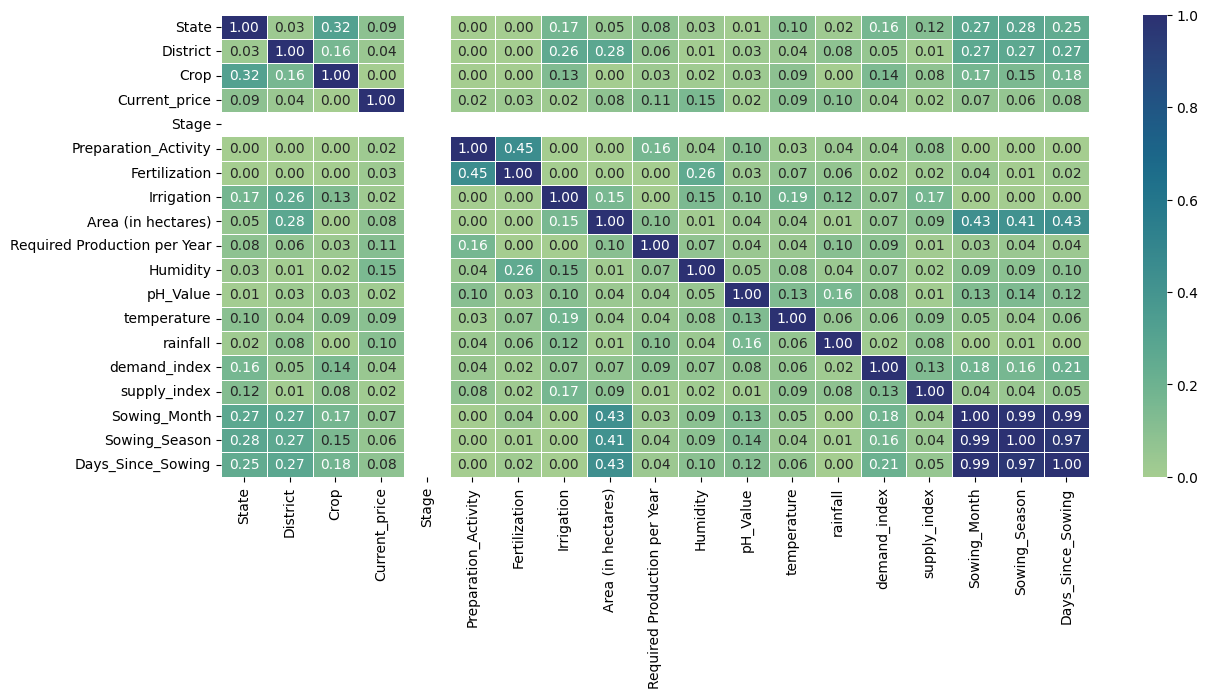

In [355]:
plt.figure(figsize=(14,6))
sns.heatmap(crop_corr_df.abs(), annot=True, fmt=".2f", linewidths=.5, cmap="crest")
plt.show()

In [356]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_features = poly.fit_transform(encode_crop_data[['Crop', 'Sowing_Season']])

In [357]:
poly.get_feature_names_out(["Crop","Sowing_Season"])

array(['Crop', 'Sowing_Season', 'Crop Sowing_Season'], dtype=object)

In [363]:
interaction_data = pd.DataFrame(interaction_features, columns = poly.get_feature_names_out(["Crop","Sowing_Season"]))
concat_crop = pd.concat([encode_crop_data, interaction_data], axis = 1)
remove_duplicate_crop_df = concat_crop.loc[:, ~concat_crop.columns.duplicated()]
remove_duplicate_crop_df.drop(["Crop","Sowing_Season"], axis = 1, inplace=True)
# remove_duplicate_crop_df

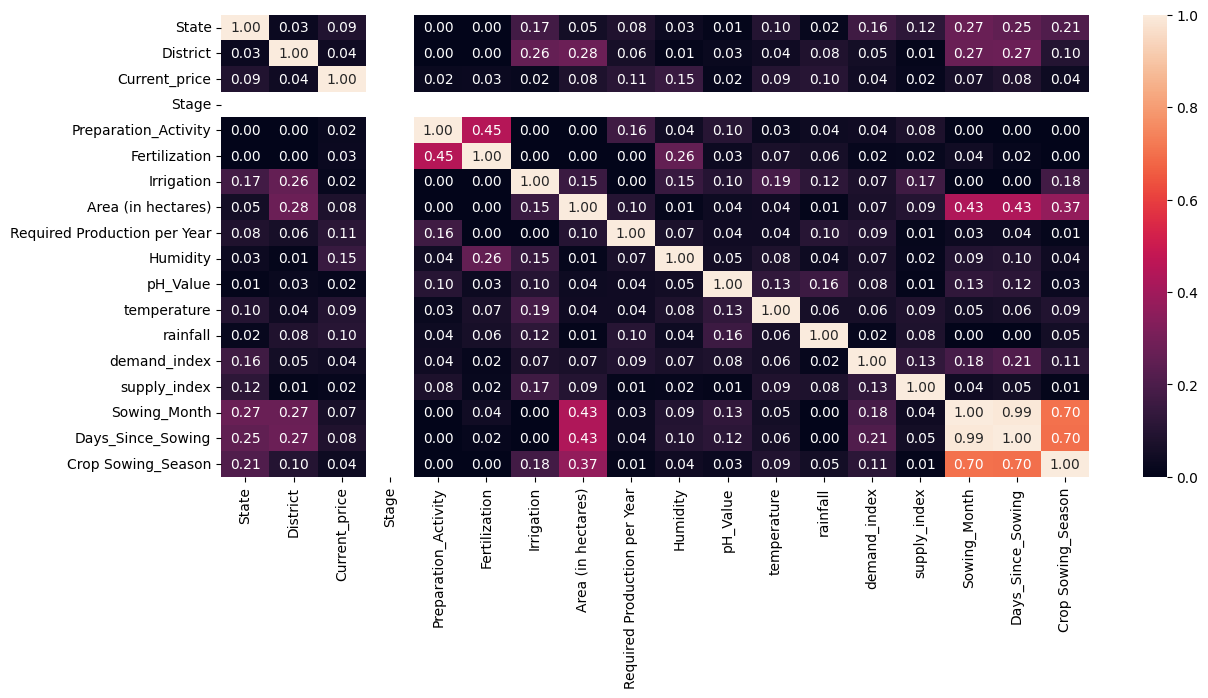

In [364]:
plt.figure(figsize=(14,6))
sns.heatmap(remove_duplicate_crop_df.corr().abs(), annot=True, fmt = ".2f")
plt.show()

Split data into features(X) and Labels(y), no need Stage feature because of it contains only one values

In [365]:
X = remove_duplicate_crop_df.drop(["Current_price","Stage"], axis = 1)
y = remove_duplicate_crop_df["Current_price"]

Lasso is used for Regularization strength of variables which means select the appropriate features to build accurate model

In [366]:
lasso = Lasso(alpha=0.01) # Adjust alpha for regularization strength
lasso.fit(X, y)

Lasso(alpha=0.01)

In [367]:
lasso_model = SelectFromModel(lasso, prefit=True)
X.columns[lasso_model.get_support()].tolist()


['State',
 'District',
 'Preparation_Activity',
 'Fertilization',
 'Irrigation',
 'Area (in hectares)',
 'Required Production per Year',
 'Humidity',
 'pH_Value',
 'temperature',
 'rainfall',
 'demand_index',
 'supply_index',
 'Sowing_Month',
 'Days_Since_Sowing',
 'Crop Sowing_Season']

There is no specifc correlated features to remove while using Lasso

In [368]:
corrl = crop_corr_df["Current_price"].abs().sort_values(ascending=False)
corrl

Current_price                   1.000000
Humidity                        0.152264
Required Production per Year    0.111251
rainfall                        0.104400
temperature                     0.094844
State                           0.088112
Days_Since_Sowing               0.083917
Area (in hectares)              0.079272
Sowing_Month                    0.066184
Sowing_Season                   0.057290
demand_index                    0.044510
District                        0.039548
Fertilization                   0.030477
Preparation_Activity            0.023852
Irrigation                      0.022154
supply_index                    0.016514
pH_Value                        0.015734
Crop                            0.002788
Stage                                NaN
Name: Current_price, dtype: float64

In [372]:
corr_matrix = X.corr().abs()

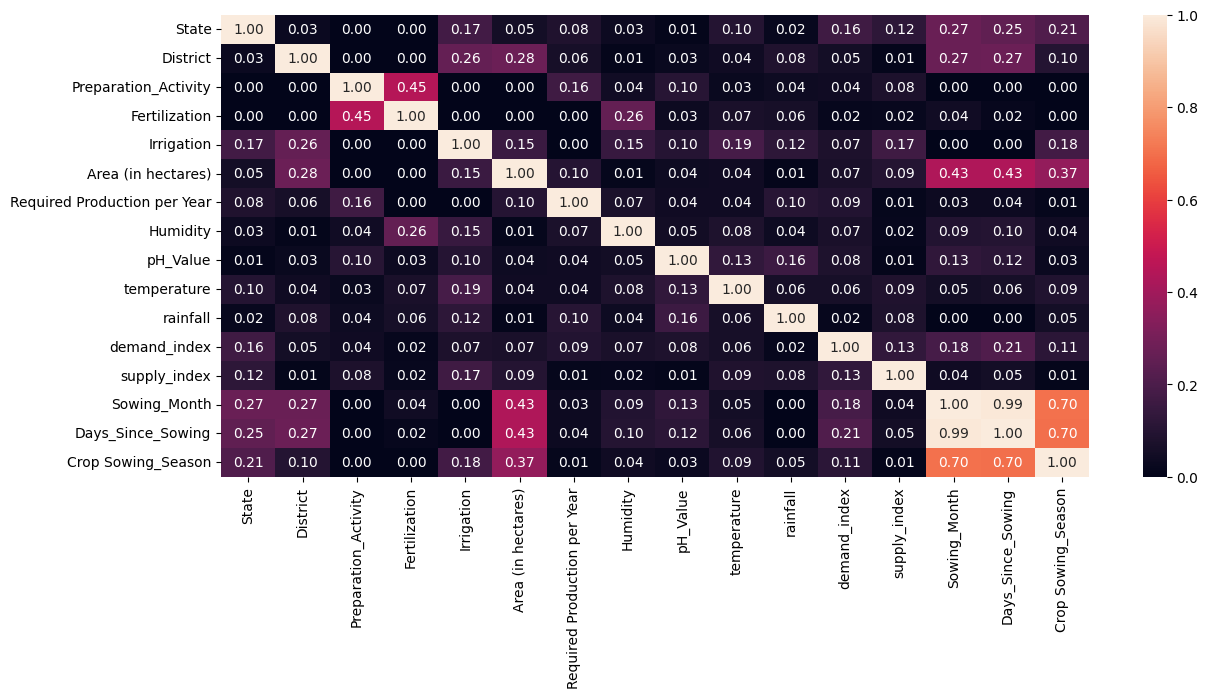

In [374]:
plt.figure(figsize=(14,6))
sns.heatmap(corr_matrix, annot=True, fmt = ".2f")
plt.show()

In [375]:
#The simplest way to remove highly correlated features is to drop one of the highly correlated features with another. 
# We can do this using the Pandas drop() method.
# get upper triangle of correlation matrix
up = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool_))

In [376]:
# find features with correlation greater than 0.90
to_drop = [column for column in up.columns if any(up[column] > 0.90)]
to_drop

['Days_Since_Sowing']

In [377]:
# drop highly correlated features
X.drop(to_drop, axis=1, inplace=True)

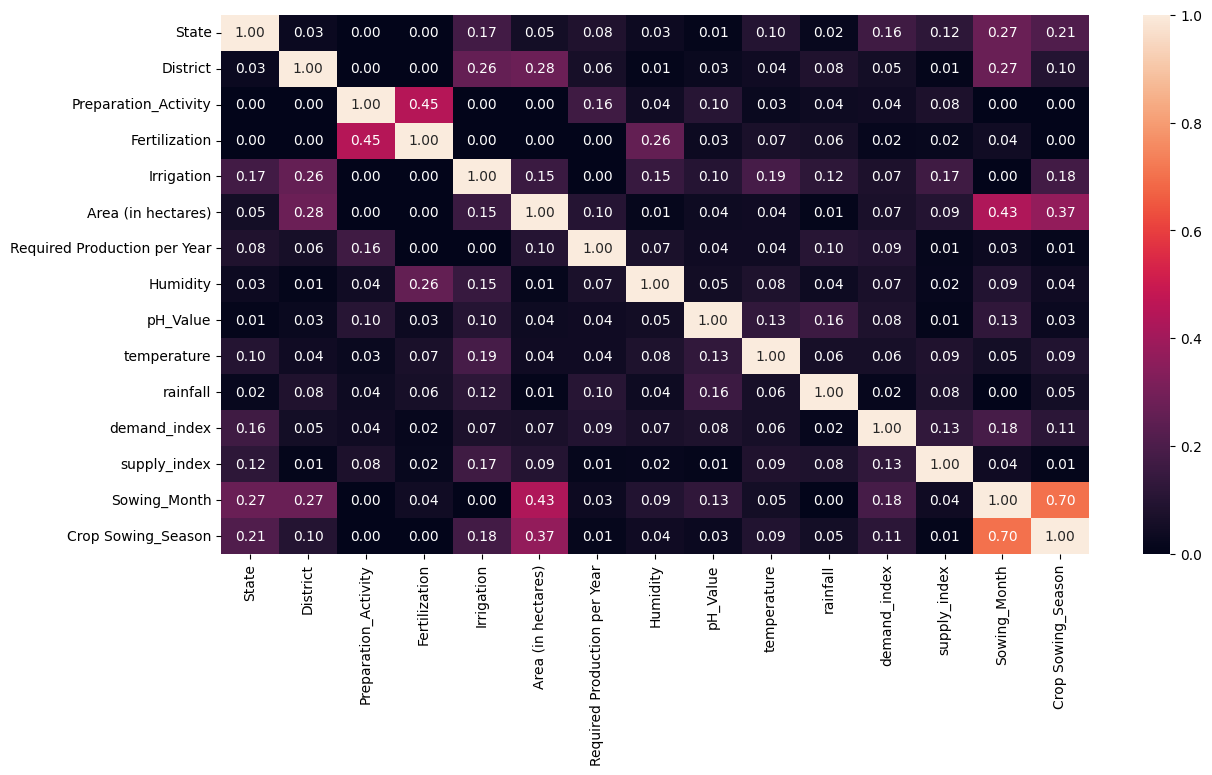

In [379]:
plt.figure(figsize=(14, 7))
sns.heatmap(X.corr().abs(), annot=True, fmt = ".2f")
plt.show()

In [380]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Features"] = X.columns
vif

,VIF_Factor,Features
0,3.872207,State
1,4.861186,District
2,3.720017,Preparation_Activity
3,2.748169,Fertilization
4,4.410495,Irrigation
5,22.298004,Area (in hectares)
6,92.863050,Required Production per Year
7,6.459610,Humidity
8,11.255999,pH_Value
9,7.278993,temperature


In [381]:
X.shape

(132, 15)

##### Scalling the features

In [391]:
ss = StandardScaler()
X = ss.fit_transform(X)
type(y)

numpy.ndarray

In [395]:
X[:1]

array([[-0.21473125, -1.47029409, -0.4472136 ,  1.        ,  0.76088591,
        -2.27851196,  0.09949019,  1.17976868,  1.26141944,  1.27626734,
         0.45426457,  1.31146997, -1.40021856, -0.96216802, -0.5652526 ]])

##### Feature selection

In [396]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=122)

#### Model Building

##### Define function for all models at once

In [400]:
models = {"svr": SVR(), "randomforestR": RandomForestRegressor(), "gbr": GradientBoostingRegressor(), "abr": AdaBoostRegressor(), "lr": LinearRegression(), "dtr": DecisionTreeRegressor()}

In [401]:
def model_building(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for m in models.values():
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)
        # Evaluate the model
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        print(f"\n{m}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"R² Score: {r2:.2f}")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        df = pd.DataFrame([y_pred, y_test]).T
    

In [402]:
model_building(X, y)


SVR()
Root Mean Squared Error (RMSE): 1.96
R² Score: -0.06
Mean Absolute Error (MAE): 1.70

RandomForestRegressor()
Root Mean Squared Error (RMSE): 2.19
R² Score: -0.33
Mean Absolute Error (MAE): 1.87

GradientBoostingRegressor()
Root Mean Squared Error (RMSE): 2.35
R² Score: -0.52
Mean Absolute Error (MAE): 2.01

AdaBoostRegressor()
Root Mean Squared Error (RMSE): 2.24
R² Score: -0.38
Mean Absolute Error (MAE): 1.90

LinearRegression()
Root Mean Squared Error (RMSE): 2.09
R² Score: -0.21
Mean Absolute Error (MAE): 1.74

DecisionTreeRegressor()
Root Mean Squared Error (RMSE): 2.35
R² Score: -0.53
Mean Absolute Error (MAE): 1.84


##### Individual models

##### RandomForest Regressor

In [406]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=6, random_state=22)

In [407]:
# Train the model
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=10, random_state=22)

<Axes: >

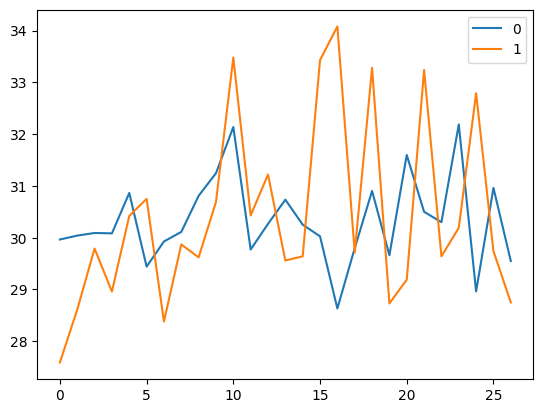

In [411]:
# Predict on the test set
rfr_pred = rfr.predict(X_test)
pd.DataFrame([rfr_pred, y_test]).T.plot()

In [421]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, rfr_pred))
r2 = r2_score(y_test, rfr_pred)
mae = mean_absolute_error(y_test, rfr_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Root Mean Squared Error (RMSE): 1.95
R² Score: -0.23
Mean Absolute Error (MAE): 1.52


##### Gradiant Boost Regressor

In [412]:
gbr = GradientBoostingRegressor(n_estimators=10, random_state=22)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=10, random_state=22)

In [413]:
bgr_pred = gbr.predict(X_test)
pd.DataFrame([bgr_pred, y_test]).T.head()

,0,1
0,30.457472,27.59
1,30.331503,28.61
2,30.604792,29.79
3,29.874910,28.96
4,30.542485,30.42


<Axes: >

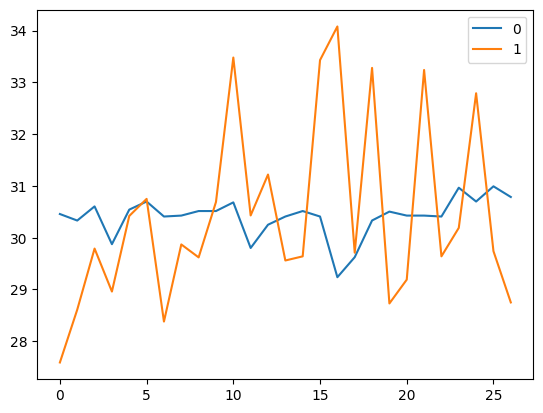

In [414]:
pd.DataFrame([bgr_pred, y_test]).T.plot()

In [422]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, bgr_pred))
r2 = r2_score(y_test, bgr_pred)
mae = mean_absolute_error(y_test, bgr_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Root Mean Squared Error (RMSE): 1.86
R² Score: -0.12
Mean Absolute Error (MAE): 1.48


##### Linear Regressor

In [415]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
df = pd.DataFrame([lr_pred, y_test]).T
df.head()

,0,1
0,29.916660,27.59
1,30.690830,28.61
2,31.118294,29.79
3,29.746694,28.96
4,30.906336,30.42


<Axes: >

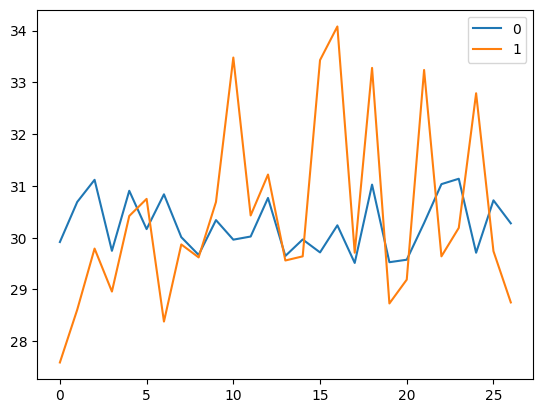

In [423]:
df.plot()

In [424]:
# The coefficients
print("Coefficients: \n", lr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, lr_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, lr_pred))

Coefficients: 
 [-0.27966031 -0.1869746   0.02243131  0.14353707 -0.06400427  0.18257385
  0.25274039 -0.28813458 -0.11659832 -0.10877255 -0.26683826 -0.11631922
 -0.08441382  0.30823402 -0.06881108]
Mean squared error: 3.35
Coefficient of determination: -0.09


##### Support Vector Regressor

<Axes: >

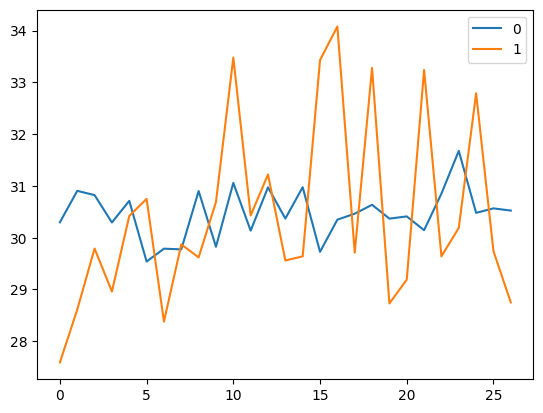

In [425]:
svm = SVR()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
pd.DataFrame([svm_pred, y_test]).T.plot()

In [426]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, svm_pred))
r2 = r2_score(y_test, svm_pred)
mae = mean_absolute_error(y_test, svm_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Root Mean Squared Error (RMSE): 1.84
R² Score: -0.10
Mean Absolute Error (MAE): 1.56


#### Hyper-parameter Tuning

In [806]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}



In [812]:
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv = 5)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 15, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [100, 200, 300]})

<Axes: >

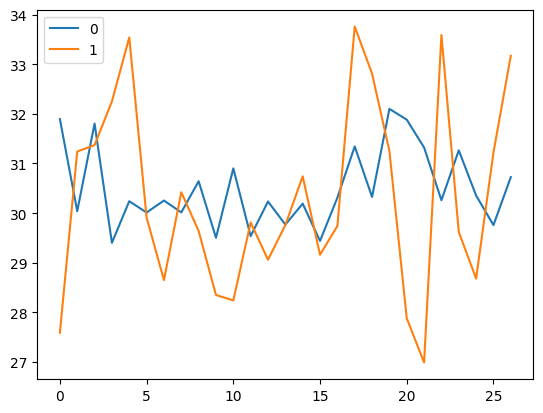

In [813]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
pd.DataFrame([y_pred_best, y_test]).T.plot()
# y_pred_best
# y_test

In [75]:

# Evaluate the best model
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)

print("\nAfter Hyperparameter Tuning:")
print(f"Best Model RMSE: {rmse_best:.2f}")
print(f"Best Model R² Score: {r2_best:.2f}")
print(f"Best Model MAE: {mae_best:.2f}")



After Hyperparameter Tuning:
Best Model RMSE: 2.08
Best Model R² Score: -0.19
Best Model MAE: 1.68
